In [2]:
import pandas as pd

# 讀取 CSV 檔案
df = pd.read_csv("df_exported.csv")
# 顯示 DataFrame 的前幾行
print(df.head())

   Release_No     MI_ID  OSTEOPOROSIS_SELF  AGE  SEX  DIABETES_SELF  \
0  ABBM042247  P0002544                  0   51    2              0   
1  ABBM070489  P0005099                  0   56    1              0   
2  ABBM071227  P0001971                  0   59    1              0   
3  ABBM069960  P0002487                  0   69    1              1   
4  ABBM089046  P0002566                  0   39    2              0   

   DIABETES_SELF_KIND  BODY_HEIGHT  BODY_WEIGHT        BMI  ...  \
0                   0        148.0    45.500000  20.772462  ...   
1                   0        164.0    64.100000  23.832540  ...   
2                   0        164.0    80.800000  30.041642  ...   
3                   2        158.5    69.900000  27.823941  ...   
4                   0        165.5    76.839995  29.243983  ...   

   HipR_Neck_Age%  HipR_Tot_Area  HipR_Tot_BMC  HipR_Tot_BMD  HipR_Tot_T  \
0           107.0          32.21         29.73         0.923        -0.2   
1            89.0 


📘 回歸模型 summary：Spine_Tot_T
                            OLS Regression Results                            
Dep. Variable:            Spine_Tot_T   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                     156.3
Date:                Thu, 01 May 2025   Prob (F-statistic):          3.63e-181
Time:                        16:31:00   Log-Likelihood:                -2971.7
No. Observations:                1837   AIC:                             5959.
Df Residuals:                    1829   BIC:                             6003.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const     

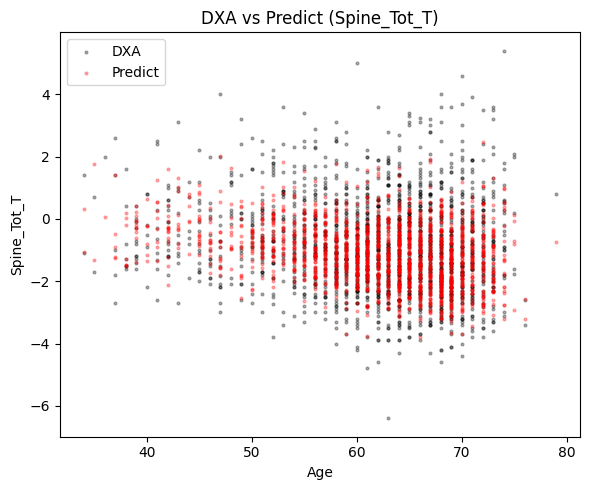


📊 差距統計 - Spine_Tot_T
平均差（DXA - 預測）: 0.235
標準差: 1.252
差距 > 0 的比例（DXA > 預測）: 54.22%
差距 > 0.5 的比例: 67.12%


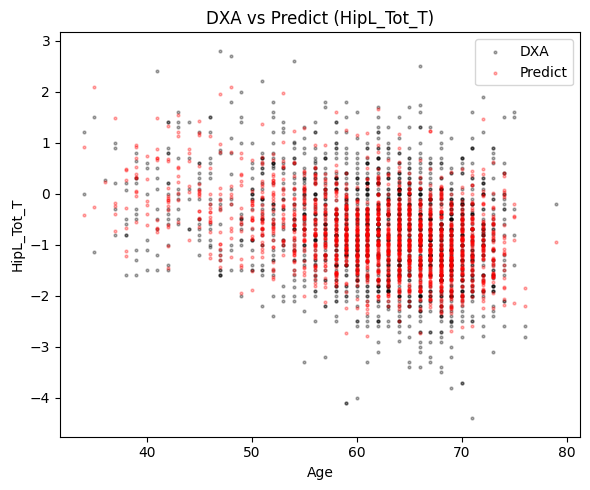


📊 差距統計 - HipL_Tot_T
平均差（DXA - 預測）: 0.093
標準差: 0.757
差距 > 0 的比例（DXA > 預測）: 54.11%
差距 > 0.5 的比例: 49.10%


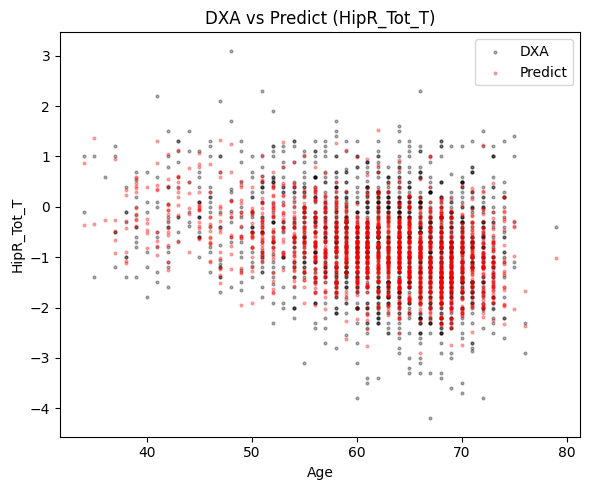


📊 差距統計 - HipR_Tot_T
平均差（DXA - 預測）: 0.120
標準差: 0.744
差距 > 0 的比例（DXA > 預測）: 55.69%
差距 > 0.5 的比例: 50.03%


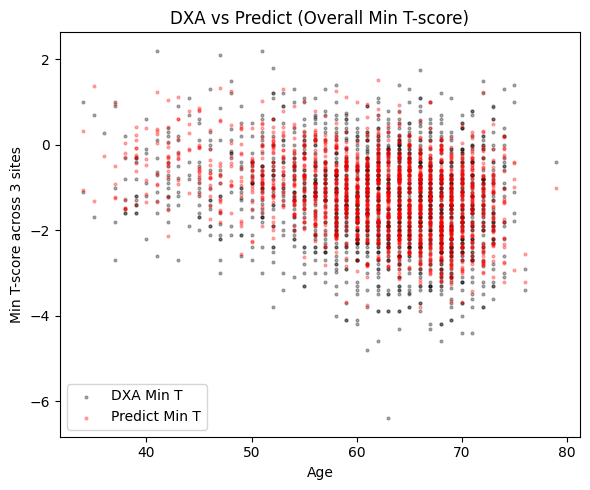


📊 整體 T 值差距統計
平均差（DXA - 預測）: -0.130
標準差: 0.893
差距 > 0 的比例（DXA > 預測）: 44.15%
差距 > 0.5 的比例: 56.34%


In [3]:
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# ==== STEP 0: 各部位專屬 predictors ====
predictors_dict = {
    'Spine_Tot_T':['AGE', 'SEX', 'BODY_HEIGHT', 'BODY_WEIGHT', 'QUS', 'AGE_x_SEX',
     'AGE_x_BODY_WEIGHT'],
    'HipL_Tot_T': ['AGE', 'SEX', 'BODY_WEIGHT', 'QUS', 'AGE_x_SEX','SEX_x_QUS'],
    'HipR_Tot_T': ['AGE', 'SEX', 'BODY_HEIGHT', 'BODY_WEIGHT', 'BODY_FAT_RATE', 'QUS',
     'AGE_x_BODY_HEIGHT', 'SEX_x_QUS', 'BODY_WEIGHT_x_BODY_FAT_RATE']
}
bmd_targets = list(predictors_dict.keys())
cutoff = -2.5

# 設交互
df['AGE_x_SEX'] = df['AGE'] * df['SEX']
df['AGE_x_BODY_HEIGHT'] = df['AGE'] * df['BODY_HEIGHT']
df['AGE_x_BODY_WEIGHT'] = df['AGE'] * df['BODY_WEIGHT']
df['AGE_x_QUS'] = df['AGE'] * df['QUS']
df['SEX_x_QUS'] = df['SEX'] * df['QUS']
df['BODY_HEIGHT_x_BODY_WEIGHT'] = df['BODY_HEIGHT'] * df['BODY_WEIGHT']
df['BODY_HEIGHT_x_QUS'] = df['BODY_HEIGHT'] * df['QUS']
df['SEX_x_BODY_WEIGHT'] = df['SEX'] * df['BODY_WEIGHT']
df['BODY_HEIGHT_x_HBA1C'] = df['BODY_HEIGHT'] * df['HBA1C']
df['BODY_WEIGHT_x_BODY_FAT_RATE'] = df['BODY_WEIGHT'] * df['BODY_FAT_RATE']
df['BODY_WEIGHT_x_HBA1C'] = df['BODY_WEIGHT'] * df['HBA1C']

# ==== STEP 1: PSM 不分性別 ====
def do_psm_all(df):
    non_t2d = df[df['DIABETES_SELF'] == 0].copy()
    t2d = df[df['DIABETES_SELF'] == 1].copy()

    match_vars = ['AGE', 'BMI', 'WHR', 'OSTEOPOROSIS_SELF', 'BODY_FAT_RATE',
                  'BODY_HEIGHT', 'BODY_WEIGHT', 'BODY_WAISTLINE', 'BODY_BUTTOCKS', 'SEX']
    scaler = StandardScaler()
    X_all = scaler.fit_transform(df[match_vars])
    y = df['DIABETES_SELF']

    ps_model = LogisticRegression().fit(X_all, y)
    df['pscore'] = ps_model.predict_proba(X_all)[:, 1]

    non_t2d = df[df['DIABETES_SELF'] == 0]
    t2d = df[df['DIABETES_SELF'] == 1]

    nn = NearestNeighbors(n_neighbors=1)
    nn.fit(non_t2d[['pscore']])
    dists, indices = nn.kneighbors(t2d[['pscore']])
    matched_non_t2d = non_t2d.iloc[indices.flatten()].copy()

    return matched_non_t2d, t2d.copy()

# ==== STEP 2: 建模 & 預測 ====
def model_and_predict(non_t2d, t2d, predictors_dict):
    models = {}
    for col, pred_vars in predictors_dict.items():
        X = sm.add_constant(non_t2d[pred_vars])
        y = non_t2d[col]
        model = sm.OLS(y, X).fit()
        models[col] = model
        print(f"\n📘 回歸模型 summary：{col}")
        print(model.summary())

        X_pred = sm.add_constant(t2d[pred_vars])
        t2d[f'{col}_pred'] = model.predict(X_pred)
    return t2d, models

# ==== STEP 3: 圖形比較 + 統計 ====
def plot_scatter_and_stats(df, col):
    pred_col = f'{col}_pred'
    plt.figure(figsize=(6, 5))
    plt.scatter(df['AGE'], df[col], color='black', alpha=0.3, s=4, label='DXA')
    plt.scatter(df['AGE'], df[pred_col], color='red', alpha=0.3, s=4, label='Predict')
    plt.xlabel("Age")
    plt.ylabel(col)
    plt.title(f"DXA vs Predict ({col})")
    plt.legend()
    plt.tight_layout()
    plt.show()

    diff = df[col] - df[pred_col]
    print(f"\n📊 差距統計 - {col}")
    print(f"平均差（DXA - 預測）: {diff.mean():.3f}")
    print(f"標準差: {diff.std():.3f}")
    print(f"差距 > 0 的比例（DXA > 預測）: {(diff > 0).mean():.2%}")
    print(f"差距 > 0.5 的比例: {(diff.abs() > 0.5).mean():.2%}")

# ==== STEP 4: 執行 ====
matched_all, t2d_all = do_psm_all(df)
t2d_result, models = model_and_predict(matched_all, t2d_all, predictors_dict)

# ==== STEP 5: 每部位散圖 + 統計 ====
for col in bmd_targets:
    plot_scatter_and_stats(t2d_result, col)

# ==== STEP 6: 預測與實際「整體骨密度」比較（取三部位最低 T 值） ====

# 計算三部位最小的實測與預測值
t2d_result['Min_T_actual'] = t2d_result[bmd_targets].min(axis=1)
t2d_result['Min_T_pred'] = t2d_result[[f"{col}_pred" for col in bmd_targets]].min(axis=1)

# 畫整體 T 值散佈圖
plt.figure(figsize=(6, 5))
plt.scatter(t2d_result['AGE'], t2d_result['Min_T_actual'], color='black', alpha=0.3, s=4, label='DXA Min T')
plt.scatter(t2d_result['AGE'], t2d_result['Min_T_pred'], color='red', alpha=0.3, s=4, label='Predict Min T')
plt.xlabel("Age")
plt.ylabel("Min T-score across 3 sites")
plt.title("DXA vs Predict (Overall Min T-score)")
plt.legend()
plt.tight_layout()
plt.show()

# 額外差異統計
diff_all = t2d_result['Min_T_actual'] - t2d_result['Min_T_pred']
print("\n📊 整體 T 值差距統計")
print(f"平均差（DXA - 預測）: {diff_all.mean():.3f}")
print(f"標準差: {diff_all.std():.3f}")
print(f"差距 > 0 的比例（DXA > 預測）: {(diff_all > 0).mean():.2%}")
print(f"差距 > 0.5 的比例: {(diff_all.abs() > 0.5).mean():.2%}")

